In [1]:
import os
import sys 
import glob
import dask
import pyproj
import copy
import dask
import xsar
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

import dask.array as da
import cmcrameri.cm as cmc
import drama.utils as drtls
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from leakage.velocity_leakage import S1DopplerLeakage, add_dca_to_leakage_class, slant2ground
from leakage.misc import round_to_hour, angular_difference, calculate_distance

In [2]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios.sort()
scenarios

['Aghulas_20190515',
 'Aghulas_20191110',
 'Aghulas_20200121',
 'Aghulas_20200309',
 'Aghulas_20200321',
 'Aghulas_20200402',
 'Aghulas_20200414',
 'Aghulas_20200426',
 'Azores_20201127',
 'Barbedos_20201110',
 'Brasilia_20200321',
 'Brasilia_20200402',
 'Carrib_20231104',
 'Hawaii_20201106',
 'Iceland_20231107',
 'Morroco_20201022',
 'Morroco_20201103',
 'Morroco_20201115',
 'Scotland_20231109']

In [3]:
scenario = 'Aghulas_20200309'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    # f0=26.5e9,
    z0 = 823_000,
    era5_directory='../../data/leakage/era5_winds/',
    resolution_product=25_000,
    az_footprint_cutoff=80_000,
    vx_sat=6_800,
    PRF=4,
    grid_spacing=600,
    antenna_length=2.87,
    antenna_height=0.32,
    beam_pattern= 'phased_array', #'phased_array', sinc
    antenna_elements=4,
    antenna_weighting=0.75,
    swath_start_incidence_angle_scat=45,
    boresight_elevation_angle_scat=40,
    random_state = 42,
    fill_nan_limit = None,

    # era5_smoothing_window=30,
    # denoise = True,
    # _pulsepair_noise = True
    # _speckle_noise= True
    )

/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:304: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


In [4]:
# test.open_data()
# test.querry_era5()
# test.wdir_from_era5()
# # test.wdir_wrt_sensor = 0
# test.create_dataset()
# test.create_beam_mask()
# test.compute_scatt_eqv_backscatter()
# test.compute_beam_pattern()
# test.compute_leakage_velocity()
# test.compute_leakage_velocity_estimate()
test.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200309/0D9A_2A1B_4B1D_63F6_9B2F_FAFB_res600.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_20200309h1800_lat-35_73_lon18_25.nc


## Misc

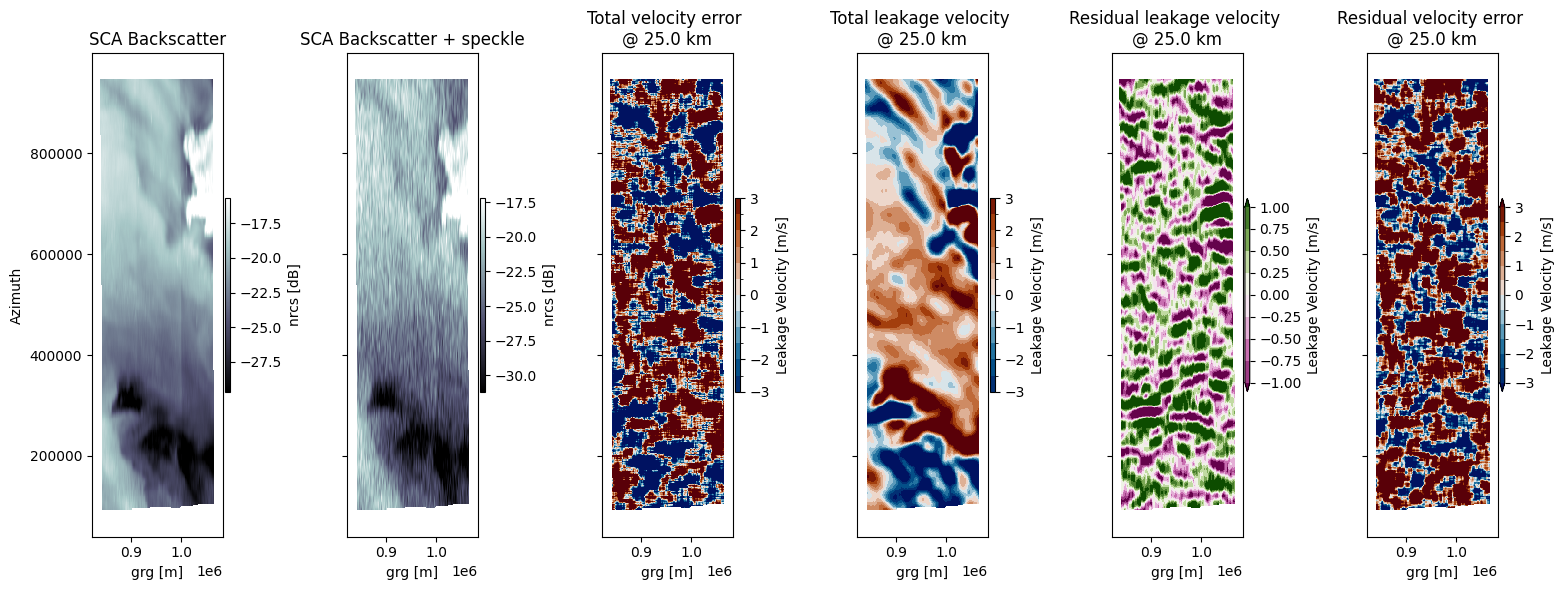

In [5]:
cbar_kwargs = {'shrink':0.4, 'aspect':40, 'pad' : 0.01, 'extend':'neither'}
plot_kwargs = {'robust': True}
plot_leakage_kwargs = {'vmin': -3, 'vmax': 3, 'cmap' : cmc.vik, 'levels' : 13}
plot_leakage_net_kwargs = {'vmin': -1, 'vmax': 1, 'cmap' : cmc.bam, 'levels' : 9}
label_kwargs = {'xlabel':'Range [m]', 'ylabel':'Azimuth [m]'}

net_leakage = test.data.V_leakage_pulse_rg_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
net_velocity_error =  test.data.V_sigma_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
nx = 6; ny = 1
fig, axes = plt.subplots(ny, nx, figsize = (16, 6), sharex=True, sharey=True)
axes_indexes = np.argwhere(axes)

LoS_comp = 1 # (1 / np.cos(test.data['elevation_angle'].mean(dim = 'az_idx')))

plot_cut = net_velocity_error / net_velocity_error

(10*np.log10(test.data.nrcs_scat * plot_cut)).T.plot(ax= axes[*axes_indexes[0]],#[0,0], 
                                          **{'cmap': 'bone', **plot_kwargs},
                                          cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
(10*np.log10(test.data.nrcs_scat_w_noise * plot_cut)).T.plot(ax= axes[*axes_indexes[1]],#[0,1], 
                                                  **{'cmap': 'bone', **plot_kwargs},
                                                  cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
(test.data.V_sigma_subscene * plot_cut * LoS_comp).T.plot(ax= axes[*axes_indexes[2]],#[0,2], 
                                             **{**plot_leakage_kwargs, **plot_kwargs},
                                             cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
(test.data.V_leakage_pulse_rg_subscene * plot_cut * LoS_comp).T.plot(ax= axes[*axes_indexes[3]],#[1,0],
                    **{**plot_leakage_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
(net_leakage  * LoS_comp).T.plot.contourf(ax= axes[*axes_indexes[4]],#[1,1],
                    **{**plot_leakage_net_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
(net_velocity_error * LoS_comp).T.plot.contourf(ax= axes[*axes_indexes[5]],#[1,2],
                    **{**plot_leakage_net_kwargs, **plot_leakage_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})

res = test.resolution_product/1000
titles = ['SCA Backscatter', 'SCA Backscatter + speckle', f'Total velocity error \n@ {res:2} km', 
          f'Total leakage velocity \n@ {res:2} km', f'Residual leakage velocity \n@ {res:2} km', f'Residual velocity error \n@ {res:2} km']
x_labels = [''] * (nx * np.max([0, ny-1])) + ['Range [m]'] * (nx * (ny-1))
y_labels = (['Azimuth'] + [''] * (nx - 1)) * ny
_ = [ax.axes.set_title(i) for ax, i in zip(axes.ravel(), titles)]
_ = [ax.axes.set_xlabel(i) for ax, i in zip(axes.ravel(), x_labels)]
_ = [ax.axes.set_ylabel(i) for ax, i in zip(axes.ravel(), y_labels)]
_ = [ax.axes.set_aspect('equal') for ax in axes.ravel()]

plt.tight_layout()

In [6]:
func_rmse = lambda x, rounding=3:  np.round(np.sqrt(np.mean(x**2)).values*1, rounding)
func_rmse(net_leakage)

0.923

In [7]:
func_rmse(test.data.V_sigma_subscene * plot_cut), func_rmse(net_velocity_error)

(5.059, 4.307)

In [8]:
func_rmse(test.data.V_leakage_pulse_rg_subscene)

2.853

In [9]:
data_dir_dca = "/Users/opodriscoll/Documents/Data/Sentinel1/DCA/"
files_dca = glob.glob(f"{data_dir_dca+scenario}/*.nc")
# files_dca = [file for file in files_dca if 'S1A' in file]
files_dca
add_dca_to_leakage_class(test, files_dca=files_dca)

In [41]:
t = 1 - np.nansum(net_velocity_error**2) / np.nansum((test.data.V_dca_pulse_rg_subscene - test.data.V_dca_pulse_rg_subscene.mean())**2)

In [40]:
np.nansum(((test.data.V_dca_pulse_rg_subscene - test.data.V_dca_pulse_rg_subscene.mean())**2).compute())

56488.453

In [43]:
t#.compute()

-59.90188980102539

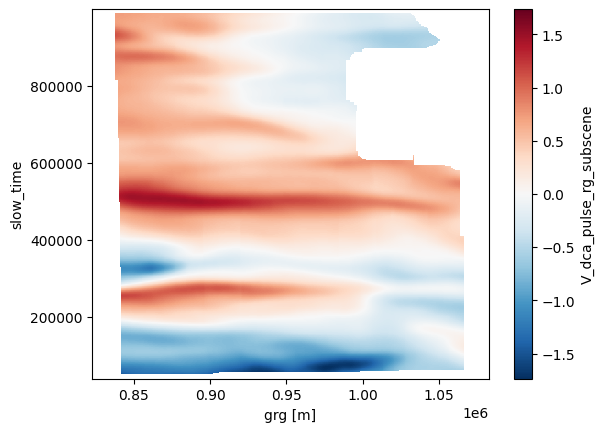

In [21]:
test.data.V_dca_pulse_rg_subscene.T.plot()